## Decision Tree Regression with AdaBoost
---

[ref] <http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#sphx-glr-auto-examples-ensemble-plot-adaboost-regression-py>

In [76]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from datetime import date
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import preprocessing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor

Data Preparation
---


In [77]:
y_data = pd.read_csv('../data/yield_w_srad.csv')
y_data.columns

Index([u'planted', u'site', u'plot', u'rep', u'id', u'dth', u'lodging',
       u'height', u'grain_type', u'moisture', u'year', u'county',
       u'trial_type', u'yield_lb', u'head_date', u'pi', u'vg_avg_tmin',
       u'vg_avg_tmax', u'fl_avg_tmin', u'fl_avg_tmax', u'gf_avg_tmin',
       u'gf_avg_tmax', u'se_avg_tmin', u'se_avg_tmax', u'veg_srad',
       u'rep_srad', u'gf_srad'],
      dtype='object')

In [78]:
y_data.head()

,planted,site,plot,rep,id,dth,lodging,height,grain_type,moisture,...,vg_avg_tmax,fl_avg_tmin,fl_avg_tmax,gf_avg_tmin,gf_avg_tmax,se_avg_tmin,se_avg_tmax,veg_srad,rep_srad,gf_srad
0,1995-05-12,RES,349.0,1,CM101,78,15.0,85.0,S,16.0,...,28.114548,15.854166,32.492108,14.893976,33.887337,14.025759,30.655951,78968,36409,49842
1,1995-05-12,RES,374.0,2,CM101,78,15.0,80.0,S,15.9,...,28.114548,15.854166,32.492108,14.893976,33.887337,14.025759,30.655951,78968,36409,49842
2,1995-05-12,RES,8.0,1,M203,87,60.0,105.0,M,23.0,...,28.114548,16.097288,33.369639,13.492801,32.751324,13.859148,30.760579,78968,49218,47679
3,1995-05-12,RES,1096.0,1,94Y589,87,10.0,95.0,M,18.7,...,28.114548,16.097288,33.369639,13.492801,32.751324,13.859148,30.760579,78968,49218,47679
4,1995-05-12,RES,350.0,1,94Y383,86,1.0,85.0,M,19.9,...,28.114548,16.101021,33.400215,13.581463,32.705987,13.873189,30.725791,78968,47809,47944


In [79]:
#drop columns that are not required
drop_col = ['year', 'county', 'site', 'id']
y_data.drop(drop_col, axis = 1, inplace = True)
y_data['planted'] = pd.to_datetime(y_data['planted'], 
                                   format = "%Y-%m-%d", infer_datetime_format = True)
y_data['head_date'] = pd.to_datetime(y_data['head_date'], 
                                     format = "%Y-%m-%d", infer_datetime_format = True)
y_data['planted_day'] = y_data['planted'].apply(lambda t: t.day)
y_data['head_day'] = y_data['head_date'].apply(lambda t: t.day)

In [136]:
# Prepare the data
y_data = y_data.dropna()
y_data['trial_type'] = pd.factorize(y_data['trial_type'])[0]
y_data['grain_type'] = pd.factorize(y_data['grain_type'])[0]

y_split = y_data.copy().drop(['planted', 'head_date', 'planted_day', 'head_day'], axis = 1)
y = y_split['yield_lb']
x = y_split.drop(['yield_lb'], axis = 1)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=5)


# Drop the 'plot' feature
xtrain_new = x_train.drop('plot', axis = 1)
xtest_new  = x_test.drop('plot', axis = 1)



# Scale the data first
xtrainnew = preprocessing.scale(xtrainnew)
xtestnew = preprocessing.scale(xtestnew)


In [73]:
rng = np.random.RandomState(1)

In [109]:
# function to generate boosting model
def get_model(model_depth=5, no_estimators=100, random_state=rng):
    
    model = AdaBoostRegressor(DecisionTreeRegressor(max_depth=model_depth),
                               n_estimators=no_estimators, random_state=random_state)
    
    return model

Parameter selection
---

* It is not clear what numbers should be used for depth and number of estimators
* Experiment to find out optimum values to prevent both under- and over- fitting

In [121]:
depths = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
validations_r2 = []
trainings_r2 = []

for depth in depths:
    
    # get the model
    reg_model = get_model(model_depth = depth)
    
    # fit training data
    reg_model.fit(xtrainnew, y_train)
    
    # calculate r2 score
    train_r2 = reg_model.score(xtrainnew, y_train)
    valid_r2 = reg_model.score(xtestnew, y_test)
    
    trainings_r2.append(train_r2)
    validations_r2.append(valid_r2)

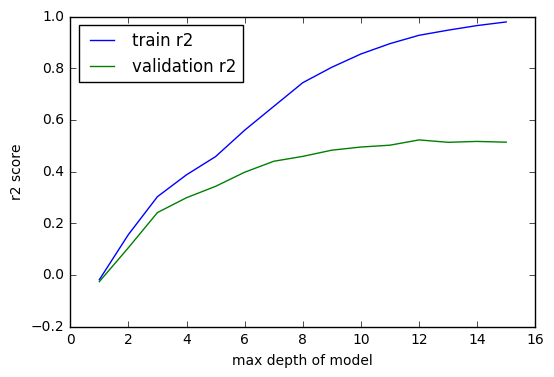

In [122]:
plt.plot(depths, trainings_r2, label ='train r2')
plt.plot(depths, validations_r2, label ='validation r2')
plt.legend(loc='upper left')
plt.xlabel('max depth of model')
plt.ylabel('r2 score')
plt.show()

It looks like the depth = 12 would be the best choice. Now testing number of estimators.

In [123]:
estimators = [1,10,20,30,40,50,60,70,80,100]

validations_r2_e = []
trainings_r2_e = []

for e in estimators:
    
    # get the model
    reg_model = get_model(model_depth = 12, no_estimators = e)
    
    # fit training data
    reg_model.fit(xtrainnew, y_train)
    
    # calculate r2 score
    train_r2 = reg_model.score(xtrainnew, y_train)
    valid_r2 = reg_model.score(xtestnew, y_test)
    
    trainings_r2_e.append(train_r2)
    validations_r2_e.append(valid_r2)

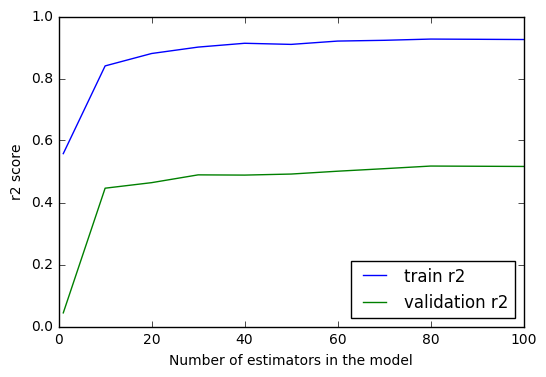

In [124]:
plt.plot(estimators, trainings_r2_e, label ='train r2')
plt.plot(estimators, validations_r2_e, label ='validation r2')
plt.legend(loc='lower right')
plt.xlabel('Number of estimators in the model')
plt.ylabel('r2 score')
plt.show()

Summary of parameter choice
---

* Depth = 12
* It looks like r2 is not very sensitive about number of estimators, so just use 100

In [129]:
final_model = get_model(model_depth = 12, no_estimators = 100)


In [130]:
final_model.fit(xtrainnew, y_train)

AdaBoostRegressor(base_estimator=DecisionTreeRegressor(criterion='mse', max_depth=12, max_features=None,
           max_leaf_nodes=None, min_impurity_split=1e-07,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort=False, random_state=None,
           splitter='best'),
         learning_rate=1.0, loss='linear', n_estimators=100,
         random_state=<mtrand.RandomState object at 0x7f04d95602d0>)

In [131]:
training_r2 = final_model.score(xtrainnew, y_train)

print 'training r2 = {}'.format(training_r2)


training r2 = 0.929730276537


In [132]:
valid_r2 = final_model.score(xtestnew, y_test)

print 'validatioin r2 = {}'.format(valid_r2)


validatioin r2 = 0.519518002214


MSE = 874344.900522, r2 = 0.519518002214


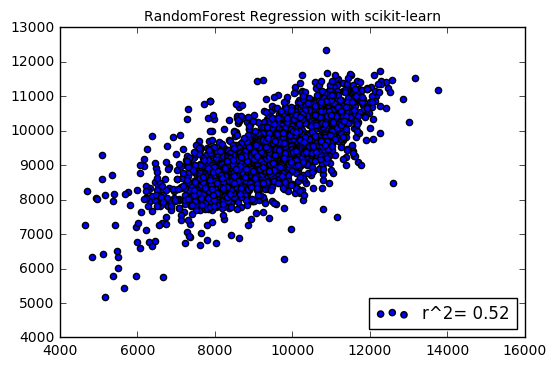

In [133]:
test_preds = final_model.predict(xtestnew)
r2 = r2_score(y_test, test_preds)
mse = mean_squared_error(y_test, test_preds)
print 'MSE = {}, r2 = {}'.format(mse, r2)

plt.scatter(y_test, test_preds, label="r^2= {:.2f}".format(r2),)
plt.legend(loc="lower right")
plt.title("RandomForest Regression with scikit-learn", size = 10)
plt.show()

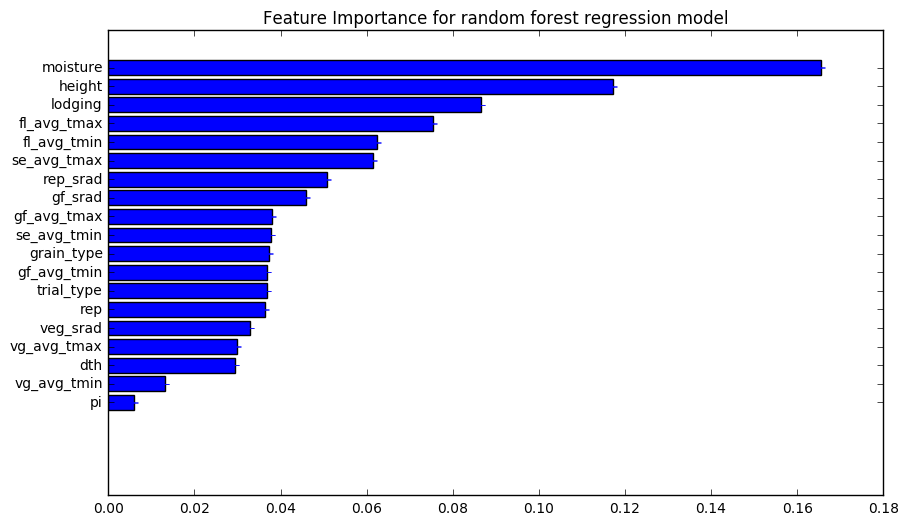

In [137]:
importance = final_model.feature_importances_
importance = pd.DataFrame(importance, index=xtrain_new.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in final_model.estimators_], axis=0)

x = range(importance.shape[0])
importance = importance.sort_values(by = 'Importance', ascending=True)
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1]

plt.figure(figsize=(10, 6))
plt.barh(x, y, yerr=yerr, align="center", )
plt.yticks(x, importance.index, rotation = 'horizontal', size = 10)
plt.title('Feature Importance for random forest regression model', size = 12)
plt.show()

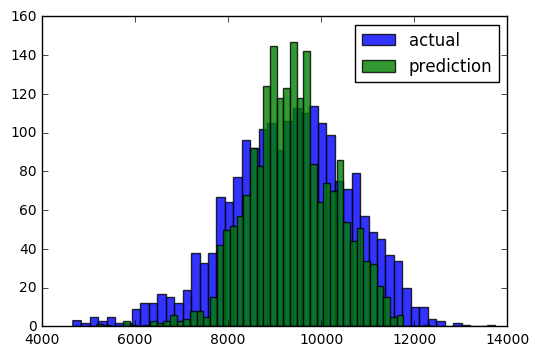

In [138]:
plt.hist(y_test, bins = 50, label = 'actual', alpha = 0.8)
plt.hist(test_preds, bins = 50, label = 'prediction', alpha = 0.8)
plt.legend()
plt.show()


## Random Forest ##
---

* result by Zamir




In [8]:
for leaf_size in [1,5,10,50]:
    random_forest = rf(n_estimators=100, oob_score= False, random_state = 5, min_samples_leaf=leaf_size)
    random_forest.fit(x_train, y_train)
    test_preds = random_forest.predict(x_test)
    r2 = r2_score(y_test, test_preds)
    mse = mean_squared_error(y_test, test_preds)
    print 'r2 = {:.2f}, MSE = {}'.format(r2, mse)

r2 = 0.57, MSE = 776332.152478
r2 = 0.56, MSE = 802581.838596
r2 = 0.53, MSE = 856870.915549
r2 = 0.43, MSE = 1030202.34458


In [9]:
random_forest = rf(n_estimators=100, oob_score= False, random_state = 5, min_samples_leaf=1)
random_forest.fit(preprocessing.scale(x_train), y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=5,
           verbose=0, warm_start=False)

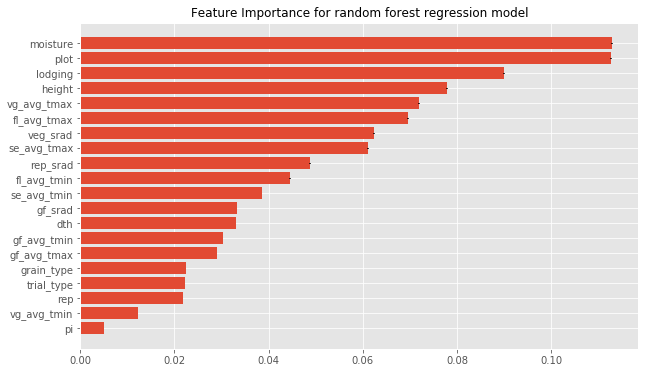

In [18]:
importance = random_forest.feature_importances_
importance = pd.DataFrame(importance, index=x_train.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in random_forest.estimators_], axis=0)

x = range(importance.shape[0])
importance = importance.sort_values(by = 'Importance', ascending=True)
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1]

plt.figure(figsize=(10, 6))
plt.barh(x, y, yerr=yerr, align="center", )
plt.yticks(x, importance.index, rotation = 'horizontal', size = 10)
plt.title('Feature Importance for random forest regression model', size = 12);

## Random Forest testing

MSE = 838277.339147, r2 = 0.539338343059


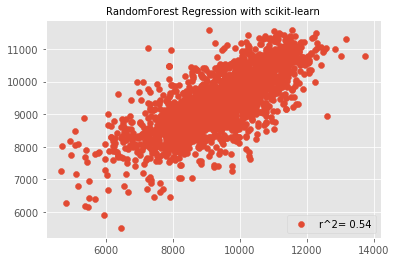

In [19]:
test_preds = random_forest.predict(preprocessing.scale(x_test))
r2 = r2_score(y_test, test_preds)
mse = mean_squared_error(y_test, test_preds)
print 'MSE = {}, r2 = {}'.format(mse, r2)

plt.scatter(y_test, test_preds, label="r^2= {:.2f}".format(r2),)
plt.legend(loc="lower right")
plt.title("RandomForest Regression with scikit-learn", size = 10);

Actual yield_lb test data
#########################
count     2066.000000
mean      9333.310761
std       1349.298262
min       4659.299163
25%       8449.491404
50%       9394.321302
75%      10262.714512
max      13744.665767
Name: yield_lb, dtype: float64


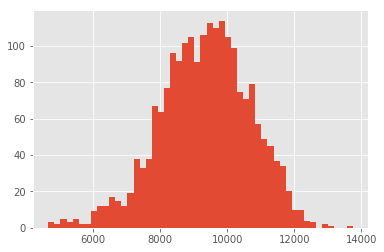

In [30]:
plt.hist(y_test, bins = 50, );
print 'Actual yield_lb test data'
print '#########################'
print y_test.describe()

Predicted yield_lb test data
#########################
count     2066.000000
mean      9345.768032
std        918.657304
min       5513.259791
25%       8739.708278
50%       9319.066509
75%       9997.916390
max      11575.220000
dtype: float64


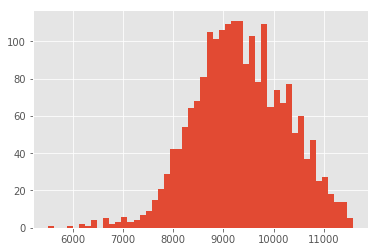

In [32]:
plt.hist(test_preds, bins = 50, );
print 'Predicted yield_lb test data'
print '#########################'
print pd.Series(test_preds).describe()

Random forest model without "PLOT"

In [37]:
xtrainnew = x_train.drop('plot', axis = 1)
xtestnew  = x_test.drop('plot', axis = 1)

In [38]:
for leaf_size in [1,5,10,50]:
    random_forest = rf(n_estimators=100, oob_score= False, random_state = 5, min_samples_leaf=leaf_size)
    random_forest.fit(xtrainnew, y_train)
    test_preds = random_forest.predict(xtestnew)
    r2 = r2_score(y_test, test_preds)
    mse = mean_squared_error(y_test, test_preds)
    print 'r2 = {:.2f}, MSE = {}'.format(r2, mse)

r2 = 0.52, MSE = 864631.302237
r2 = 0.52, MSE = 881103.321669
r2 = 0.49, MSE = 925887.966746
r2 = 0.40, MSE = 1089317.31498


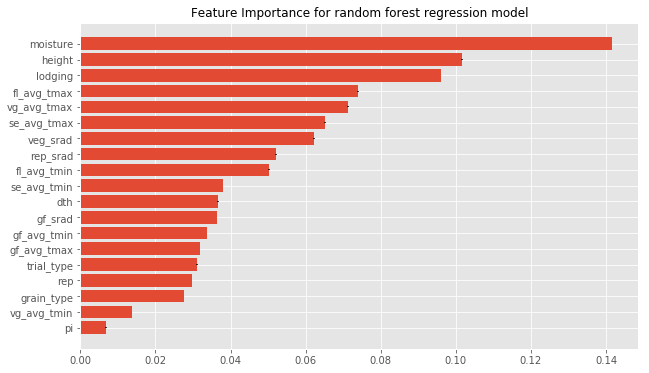

In [39]:
random_forest = rf(n_estimators=100, oob_score= False, random_state = 5, min_samples_leaf=1)
random_forest.fit(preprocessing.scale(xtrainnew), y_train)

importance = random_forest.feature_importances_
importance = pd.DataFrame(importance, index=xtrainnew.columns, 
                          columns=["Importance"])

importance["Std"] = np.std([tree.feature_importances_
                            for tree in random_forest.estimators_], axis=0)

x = range(importance.shape[0])
importance = importance.sort_values(by = 'Importance', ascending=True)
y = importance.iloc[:, 0]
yerr = importance.iloc[:, 1]

plt.figure(figsize=(10, 6))
plt.barh(x, y, yerr=yerr, align="center", )
plt.yticks(x, importance.index, rotation = 'horizontal', size = 10)
plt.title('Feature Importance for random forest regression model', size = 12);

MSE = 903927.734153, r2 = 0.50326123787


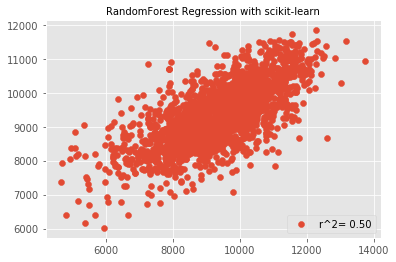

In [40]:
test_preds = random_forest.predict(preprocessing.scale(xtestnew))
r2 = r2_score(y_test, test_preds)
mse = mean_squared_error(y_test, test_preds)
print 'MSE = {}, r2 = {}'.format(mse, r2)

plt.scatter(y_test, test_preds, label="r^2= {:.2f}".format(r2),)
plt.legend(loc="lower right")
plt.title("RandomForest Regression with scikit-learn", size = 10);

Actual yield_lb test data
#########################
count     2066.000000
mean      9333.310761
std       1349.298262
min       4659.299163
25%       8449.491404
50%       9394.321302
75%      10262.714512
max      13744.665767
Name: yield_lb, dtype: float64


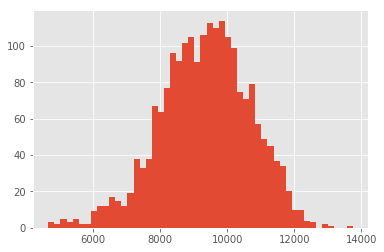

In [41]:
plt.hist(y_test, bins = 50, );
print 'Actual yield_lb test data'
print '#########################'
print y_test.describe()

Predicted yield_lb test data
#########################
count     2066.000000
mean      9361.145035
std        903.512342
min       6020.139615
25%       8764.183319
50%       9328.280977
75%       9979.842252
max      11838.047777
dtype: float64


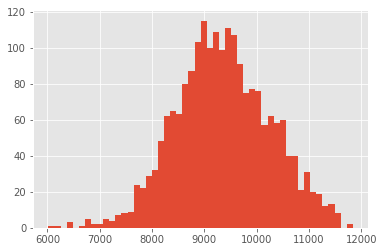

In [42]:
plt.hist(test_preds, bins = 50, );
print 'Predicted yield_lb test data'
print '#########################'
print pd.Series(test_preds).describe()